In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pprint import pprint
from skimage.io import imread
import utils
import torch
from torch import nn
import torchvision
from torchvision.transforms import ToTensor
print(f'Pytorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')
from PIL import Image

Pytorch version: 2.0.0+cpu, Torchvision version: 0.15.1+cpu


In [2]:
path=glob.glob(os.path.join('MURA-v1.1','*','*','*', '*','*.png'))
pprint(path)


['MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient0

We try to concatenate all the info about the images in one dataset
We use the character '\\' because one '\' is the escape and the other separates the subfolders in our OS (Windows). if we worked in linux we would use the character '/'
THere are two studies :study 1 and study 2

In [3]:
everythingScans_df=pd.DataFrame(dict(path=path))
everythingScans_df['Split']=everythingScans_df['path'].map(lambda x:x.split('\\')[1])
everythingScans_df['Bone']=everythingScans_df['path'].map(lambda x:x.split('\\')[2])
everythingScans_df['Patient']=everythingScans_df['path'].map(lambda x:x.split('\\')[3])
everythingScans_df['FolderName']=everythingScans_df['path'].map(lambda x:x.split('\\')[4])
everythingScans_df['Study']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[0])
everythingScans_df['Label']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[1])
everythingScans_df.sample(10)

path  Split       Bone  \
28005  MURA-v1.1\train\XR_WRIST\patient03181\study1_n...  train   XR_WRIST   
13058  MURA-v1.1\train\XR_HAND\patient07896\study1_ne...  train    XR_HAND   
13082  MURA-v1.1\train\XR_HAND\patient08138\study1_ne...  train    XR_HAND   
31102  MURA-v1.1\train\XR_WRIST\patient07081\study1_p...  train   XR_WRIST   
35187  MURA-v1.1\train\XR_WRIST\patient08548\study1_n...  train   XR_WRIST   
39861  MURA-v1.1\valid\XR_WRIST\patient11345\study1_n...  valid   XR_WRIST   
13616  MURA-v1.1\train\XR_HAND\patient09836\study1_po...  train    XR_HAND   
39974  MURA-v1.1\valid\XR_WRIST\patient11382\study1_n...  valid   XR_WRIST   
6631   MURA-v1.1\train\XR_FINGER\patient03600\study1_...  train  XR_FINGER   
30620  MURA-v1.1\train\XR_WRIST\patient06920\study1_p...  train   XR_WRIST   

            Patient       FolderName   Study     Label  
28005  patient03181  study1_negative  study1  negative  
13058  patient07896  study1_negative  study1  negative  
13082  patient08138  study1_negative  study1  negative  
31102  patient07081  study1_positive  study1  positive  
35187  patient08548  study1_negative  study1  negative  
39861  patient11345  study1_negative  study1  negative  
13616  patient09836  study1_positive  study1  positive  
39974  patient11382  study1_negative  study1  negative  
6631   patient03600  study1_positive  study1  positive  
30620  patient06920  study1_positive  study1  positive

We check if some data is missing

In [4]:
print(everythingScans_df.isnull().values.any())
a=[0 if (x=='positive' or x=='negative') else 1 for x in everythingScans_df['Label'] ]
print(sum(a))

False
0


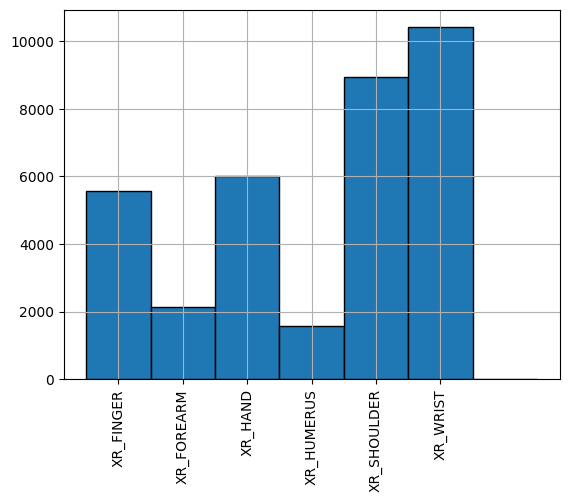

In [5]:

everythingScans_df['Bone'].hist(bins=range(1,9),rwidth=1, align='left',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

# Explore some examples of images
When groupping by two values we need to define how the values will be combined.
get combinations of pics with same label and bone then choose one randomly 

In [6]:
onePairPic_df=everythingScans_df.groupby(['Label','Bone']).apply(lambda x:x.sample(1))
onePairPic_df.reset_index(drop=True)

path  Split         Bone  \
0   MURA-v1.1\train\XR_ELBOW\patient05611\study2_n...  train     XR_ELBOW   
1   MURA-v1.1\train\XR_FINGER\patient04314\study1_...  train    XR_FINGER   
2   MURA-v1.1\train\XR_FOREARM\patient09505\study1...  train   XR_FOREARM   
3   MURA-v1.1\train\XR_HAND\patient10648\study1_ne...  train      XR_HAND   
4   MURA-v1.1\valid\XR_HUMERUS\patient11331\study1...  valid   XR_HUMERUS   
5   MURA-v1.1\train\XR_SHOULDER\patient02637\study...  train  XR_SHOULDER   
6   MURA-v1.1\valid\XR_WRIST\patient11233\study2_n...  valid     XR_WRIST   
7   MURA-v1.1\train\XR_ELBOW\patient05171\study1_p...  train     XR_ELBOW   
8   MURA-v1.1\train\XR_FINGER\patient03658\study1_...  train    XR_FINGER   
9   MURA-v1.1\train\XR_FOREARM\patient07903\study1...  train   XR_FOREARM   
10  MURA-v1.1\train\XR_HAND\patient10058\study1_po...  train      XR_HAND   
11  MURA-v1.1\train\XR_HUMERUS\patient02774\study1...  train   XR_HUMERUS   
12  MURA-v1.1\train\XR_SHOULDER\patient00861\study...  train  XR_SHOULDER   
13  MURA-v1.1\train\XR_WRIST\patient07018\study1_p...  train     XR_WRIST   

         Patient       FolderName   Study     Label  
0   patient05611  study2_negative  study2  negative  
1   patient04314  study1_negative  study1  negative  
2   patient09505  study1_negative  study1  negative  
3   patient10648  study1_negative  study1  negative  
4   patient11331  study1_negative  study1  negative  
5   patient02637  study1_negative  study1  negative  
6   patient11233  study2_negative  study2  negative  
7   patient05171  study1_positive  study1  positive  
8   patient03658  study1_positive  study1  positive  
9   patient07903  study1_positive  study1  positive  
10  patient10058  study1_positive  study1  positive  
11  patient02774  study1_positive  study1  positive  
12  patient00861  study1_positive  study1  positive  
13  patient07018  study1_positive  study1  positive

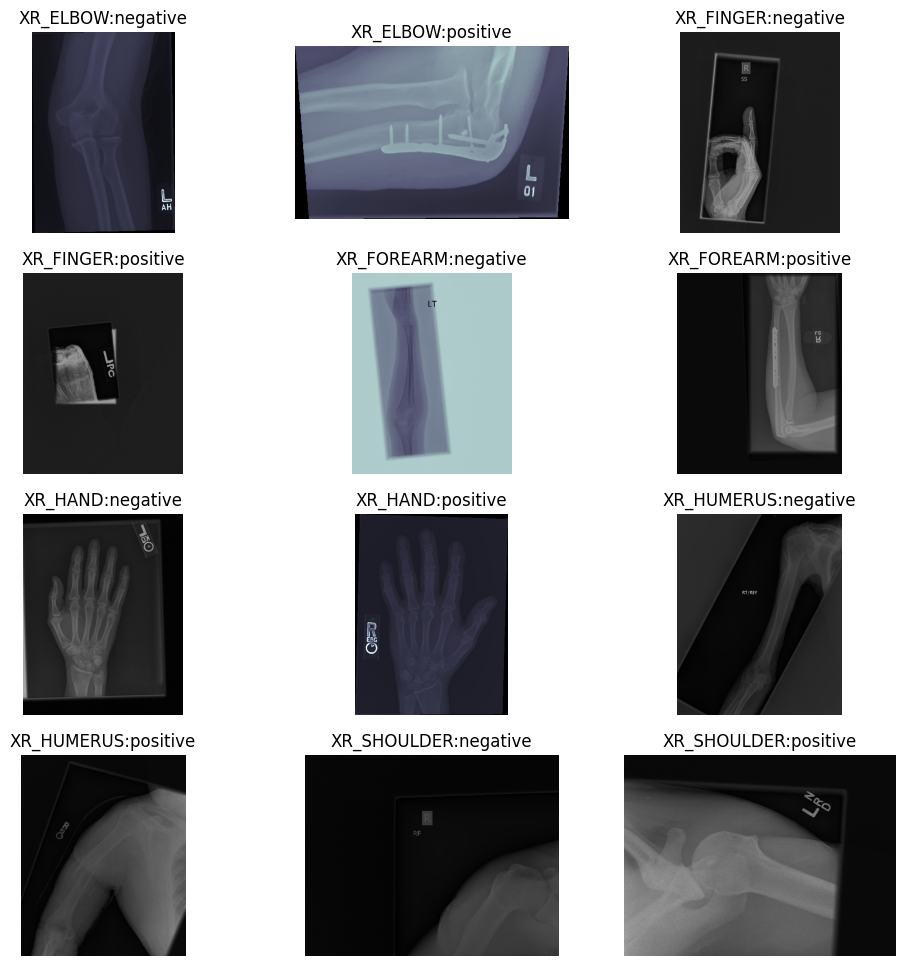

In [7]:
sub_df = everythingScans_df.groupby(['Bone', 'Label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Bone}:{Label}'.format(**c_row))

In [8]:
# try working only on humerus

humerus_df=everythingScans_df.loc[everythingScans_df['Bone']=='XR_HUMERUS'].copy()
humerus_df.sample(10)

path  Split        Bone  \
38727  MURA-v1.1\valid\XR_HUMERUS\patient11678\study1...  valid  XR_HUMERUS   
38669  MURA-v1.1\valid\XR_HUMERUS\patient11653\study1...  valid  XR_HUMERUS   
17621  MURA-v1.1\train\XR_HUMERUS\patient02737\study1...  train  XR_HUMERUS   
17717  MURA-v1.1\train\XR_HUMERUS\patient02778\study1...  train  XR_HUMERUS   
38668  MURA-v1.1\valid\XR_HUMERUS\patient11652\study1...  valid  XR_HUMERUS   
18600  MURA-v1.1\train\XR_HUMERUS\patient03188\study1...  train  XR_HUMERUS   
18076  MURA-v1.1\train\XR_HUMERUS\patient02938\study1...  train  XR_HUMERUS   
18436  MURA-v1.1\train\XR_HUMERUS\patient03109\study1...  train  XR_HUMERUS   
17752  MURA-v1.1\train\XR_HUMERUS\patient02795\study1...  train  XR_HUMERUS   
38576  MURA-v1.1\valid\XR_HUMERUS\patient11608\study1...  valid  XR_HUMERUS   

            Patient       FolderName   Study     Label  
38727  patient11678  study1_negative  study1  negative  
38669  patient11653  study1_positive  study1  positive  
17621  patient02737  study1_positive  study1  positive  
17717  patient02778  study1_positive  study1  positive  
38668  patient11652  study1_positive  study1  positive  
18600  patient03188  study1_negative  study1  negative  
18076  patient02938  study1_positive  study1  positive  
18436  patient03109  study1_negative  study1  negative  
17752  patient02795  study1_positive  study1  positive  
38576  patient11608  study1_positive  study1  positive

In [25]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import skimage
from skimage.color import gray2rgb
from torchvision import transforms,io
class NoneTransform:
    def __call__(self, im):
        return im
    
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size=output_size

    def __call__(self,image):
        height,width=image.shape[1],image.shape[2]
        if isinstance(self.output_size,int):
            if height>width:
                new_height,new_width=self.output_size*height/width,self.output_size
            else:
                new_height,new_width=self.output_size,self.output_size*width/height

            new_height,new_width=int(new_height),int(new_width)
            image=skimage.transform.resize(image,(new_height,new_width))
        return image




class HumerusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = self.df['Label'].map({'positive': 1, 'negative': 0})
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        path=self.df['path'].iloc[idx]
        # this does not works???
        img = Image.open(path)
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x:x.repeat(3,1,1)) if img.mode!='RGB' else NoneTransform(),
            ])    
            #self.transform=NoneTransform()s
        img = self.transform(img)
        return img, self.labels.iloc[idx]

torch.Size([3, 256, 256]) 0
<class 'torch.Tensor'>


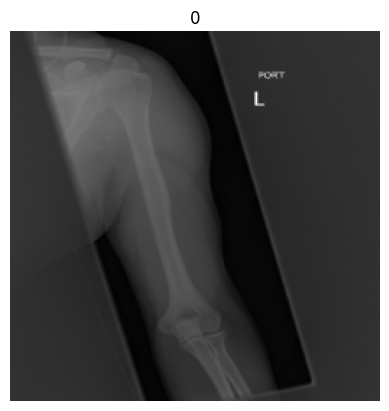

In [28]:
data_transforms = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.ToTensor()
])

img, label = HumerusDataset(humerus_df,data_transforms).__getitem__(5)
#shape attributed evaluated at runtime depending on the dataset implementation
print(img.shape, label)
print(type(img))
utils.show_image_w_label(img, label)

In [12]:
BATCH_SIZE=32
train_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='train'].copy()), batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='valid'].copy()), batch_size=BATCH_SIZE, shuffle=True)


# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, valid_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001A4EC8CD6C0>, <torch.utils.data.dataloader.DataLoader object at 0x000001A4EC8D96F0>)
Length of train dataloader: 40 batches of 32
Length of test dataloader: 9 batches of 32


In [13]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

RuntimeError: stack expects each tensor to be equal size, but got [3, 512, 456] at entry 0 and [3, 512, 512] at entry 1